<img src="images/banner2.png" alt="banner" width="150" height="100">

# **Analyse:** weerdata Noordoostpolder
In dit notebook gaan we de verzamelde data opnieuw inlezen en gebruiken voor het visualiseren.<br>
Op basis van de visualisaties gaan we de vragen over het weer in de NOP beantwoorden.<br>

<img src="images/nop1.jpg" alt="nop" width="650" height="400">

## Benodigde modules importeren

Voor dit notebook zijn de volgende modules nodig:<br>
* **pandas** (voor het opschonen/aanpassen van de data en exporteren naar CSV)<br>
* **matplotlib** (voor visualisaties in python)<br>
* **numpy** (voor wiskunde berekeningen)<br>
* **datetime** (voor ophalen datum/uur vandaag voor filtering)
* **PdfPages** (om visuals te exporteren naar PDF)


In [56]:
# module import

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

## Vragen beantwoorden
Hieronder gaan we op basis van de gecreerde databestanden (CSV) de vragen beantwoorden aan de hand van een aantal visualisaties die we<br>
kunnen maken met de python library: **matplotlib**.<br>
De visuals en antwoorden kunnen als laatste stap worden opgeslagen als een PDF-rapport voor betere leesbaarheid.

We beginnen met het laden van de CSV-bestanden en deze om te zetten naar een pandas-dataframe, dit gebruiken we als input voor matplotlib.


**BELANGRIJK:** ***altijd eerst de data updaten via de verzamel-notebook zodat de CSV-bestanden up-to-date zijn!***

In [57]:
# CSV-bestanden inladen
df_openmeteo = pd.read_csv("data/noordoostpolder_openmeteo_clean_2015_2025_latest_version.csv")
df_metnorway = pd.read_csv("data/noordoostpolder_metnorway_clean_2015_2025_latest_version.csv")

# data verkennen
#print(f"Open-Meteo dataframe:{df_openmeteo.head()}")
#print(f"Met Norway dataframe:{df_metnorway.head()}")

We maken ook een aparte lijst waarin de visuals worden opgeslagen als nummer zodat we op het laatst een rapport kunnen uitdraaien in PDF-formaat.<br>
Ook gebruiken we een functie om de antwoorden netjes toe te voegen aan het rapport.

In [58]:
# lijst maken van visuals om op het einde uit te draaien 
all_figures = []

def create_text_page(text, title=None):                     # definieer een functie die een tekstpagina als figuur maakt
    fig = plt.figure(figsize=(4.20, 6.69))                  # maak een nieuwe figuur met een vaste pagina-achtige grootte
    plt.axis("off")                                         # zet de assen uit zodat de pagina schoon oogt zonder randen
    y = 0.95                                                # startpositie voor tekst bijna bovenaan de pagina

    if title:                                               # controleer of er een titel is meegegeven
        plt.text(0.05, y, title,                            # plaats de titel linksboven op de pagina
                 ha="left", va="top",                       # horizontaal links, verticaal uitgelijnd aan de bovenkant
                 fontsize=12, fontweight="bold")            # maak de titel groter en vetgedrukt
        y -= 0.1                                            # verlaag de y-positie zodat de hoofdtekst eronder komt

    plt.text(0.05, y, text,                                 # plaats de hoofdtekst op de pagina
             ha="left", va="top",                           # links uitlijnen, bovenkant van de tekst op y
             fontsize=10, fontstyle="italic",               # iets kleinere tekst en cursief voor stijl
             wrap=True)                                     # zorg dat lange regels automatisch worden afgebroken

    return fig                                              # geef de figuur


### 1. *Hoe ontwikkelde de gemiddelde dagtemperatuur zich in de dorpen van de Noordoostpolder in de afgelopen 10 jaar?*


Om deze vraag te beantwoorden gaan we groeperen op dorp en jaar in de periode van 2015-2025.<br> 
We gebruiken hiervoor de historische dataset van Open-Meteo.<br>
In de volgende stap kunnen we de nieuwe dataframe gebruiken om te plotten met matplotlib.

In [59]:
# gemiddelde temperatuur per jaar per dorp op basis van Open-Meteo data (dagelijks gemiddelde)
df_jaar_gem_temp = df_openmeteo.groupby(["dorp", "jaar"])["gem_temp"].mean().round(1).reset_index()

# resultaten bekijken
#df_maandgem.head(5)

Hieronder de visualisatie om vraag 1 te beantwoorden:

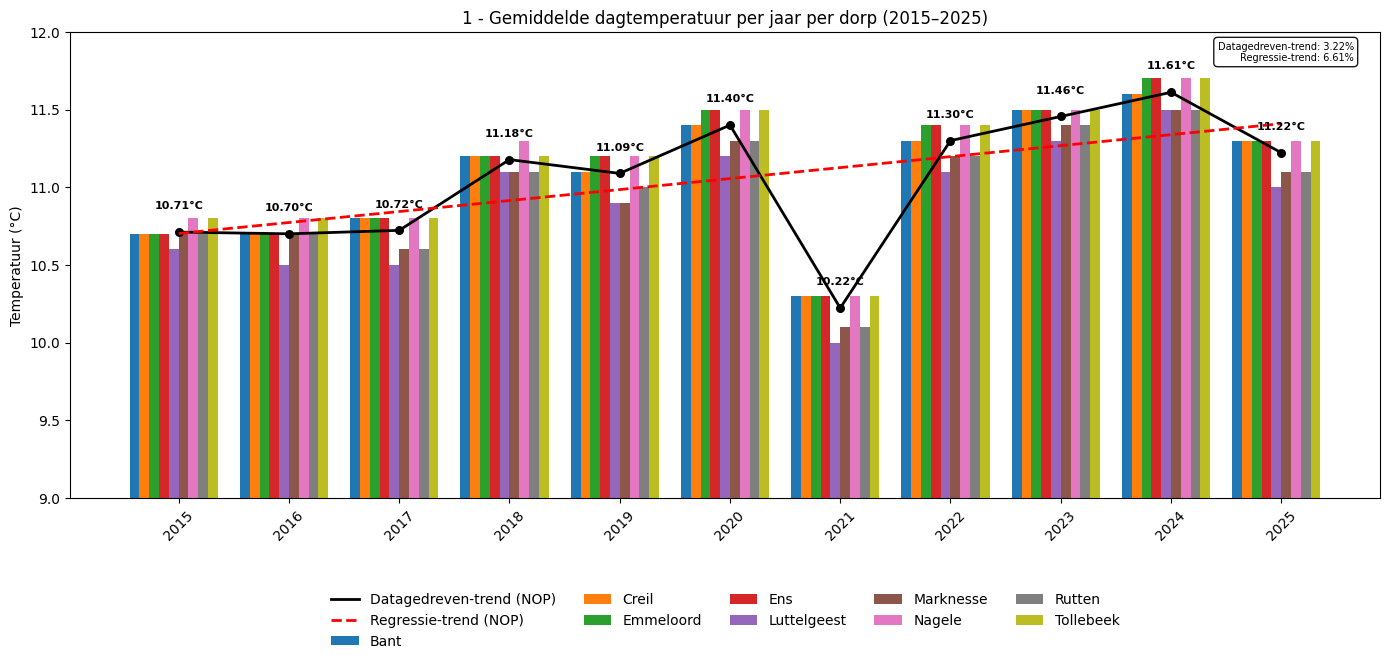

In [60]:
### VISUAL 1: Gemiddelde dagtemperatuur per jaar per dorp (2015–2025) ###

# unstack zodat je een tabel krijgt: index = jaar, kolommen = dorpen
df_bar = df_jaar_gem_temp.groupby(["jaar", "dorp"])["gem_temp"].mean().unstack() # gemiddelde per jaar per dorp

# plotten van de bar chart
fig1 = plt.figure(figsize=(14,7)) # figuur grootte

# --- bars instellingen ---

# breedte van de bars
n_dorpen = len(df_bar.columns) # aantal dorpen
x = np.arange(len(df_bar.index)) # x-waarden voor de jaren
width = 0.8 / n_dorpen # totale breedte 0.8 verdeeld over aantal dorpen

# bars tekenen
for i, dorp in enumerate(df_bar.columns): # voor elk dorp
    plt.bar(x + i*width, df_bar[dorp], width, label=dorp) # bars tekenen met verschuiving


# jaargemiddelden
jaar_gem = df_bar.mean(axis=1) # gemiddelde over alle dorpen per jaar

# --- DATAGEDREVEN TREND (zwarte lijn) ---

# datagedreven lijn (zwarte lijn)
trend_x = x + width*n_dorpen/2 # midden van de bars
trend_y = jaar_gem.values # waarden van jaargemiddelden
plt.plot(trend_x, trend_y, color="black", linewidth=2, label="Datagedreven-trend (NOP)") # tekenen datagedreven lijn

# labels op datagedreven lijn
for i, value in enumerate(jaar_gem): 
    plt.scatter(trend_x[i], trend_y[i], color="black", s=30) # punten tekenen
    plt.text(trend_x[i], trend_y[i] + 0.15, f"{value:.2f}°C", # tekst boven de punten
             ha="center", fontsize=8, fontweight="bold", color="black") # tekstinstellingen

# datagedreven percentage (echte data%)
real_start = jaar_gem.iloc[0]          # waarde in 2015
real_mean = jaar_gem.mean()            # gemiddelde over alle jaren
real_pct = ((real_mean - real_start) / real_start) * 100 

# --- REGRESSIELIJN (rode lijn) ---

# regressielijn berekenen
z = np.polyfit(x, jaar_gem, 1) # lineaire regressie (1e graads polynoom)
p = np.poly1d(z) # polynoomfunctie maken
trendline_y = p(x) # waarden van de regressielijn berekenen

# tekenen regressielijn
plt.plot(trend_x, trendline_y, color="red", linestyle="--", linewidth=2, label="Regressie-trend (NOP)") # tekenen regressielijn

# regressie percentage (regressie%)
reg_start = trendline_y[0] # # eerste waarde
reg_end = trendline_y[-1] # laatste waarde
reg_pct = ((reg_end - reg_start) / reg_start) * 100   

# --- samenvattende box rechtsboven ---
summary_text = (
    f"Datagedreven-trend: {real_pct:.2f}%\n"
    f"Regressie-trend: {reg_pct:.2f}%"
)

# tekstbox tekenen
plt.gca().text(
    0.98, 0.98,
    summary_text,
    transform=plt.gca().transAxes, # positie in assen coördinaten
    fontsize=7,
    color="black",
    ha="right",
    va="top",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round,pad=0.4",
        alpha=0.9
    )
)

# titels en labels
plt.title("1 - Gemiddelde dagtemperatuur per jaar per dorp (2015–2025)")
plt.xlabel("")
plt.ylabel("Temperatuur (°C)")

# y-as instellingen
plt.ylim(9, 12) # vaste limieten
plt.yticks(np.arange(9, 12.1, 0.5)) # stappen van 0.5°C
# x-as instellingen
plt.xticks(trend_x, df_bar.index, rotation=45)
# legenda onderaan
plt.legend(
    loc='lower center', # positie
    bbox_to_anchor=(0.5, -0.35), # buiten de plot
    ncol=5, # aantal kolommen
    frameon=False # geen kader
)

# layout en tonen
plt.tight_layout() # layout optimaliseren, geen overlapping etc
plt.show() # plot tonen

# visual toevoegen aan lijst
all_figures.append(fig1)

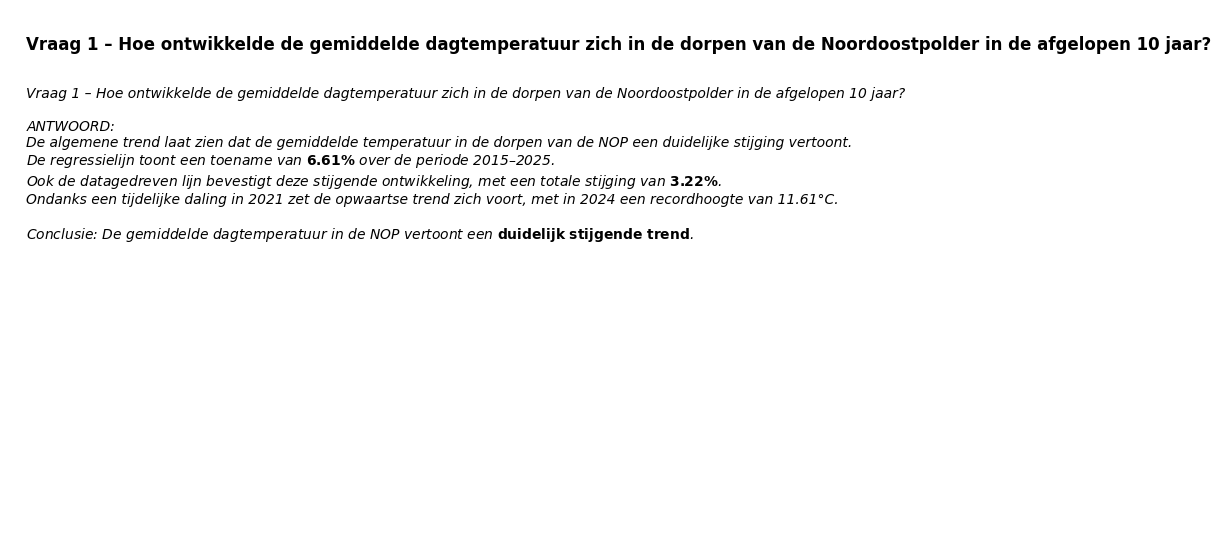

In [61]:
# vraag 1 dynamisch beantwoorden + toevoegen aan rapport
antwoord_vraag_1 = (
    "Vraag 1 – Hoe ontwikkelde de gemiddelde dagtemperatuur zich in de dorpen van de Noordoostpolder in de afgelopen 10 jaar?\n"
    f"\n"
    "ANTWOORD:\n"
    "De algemene trend laat zien dat de gemiddelde temperatuur in de dorpen van de NOP "
    "een duidelijke stijging vertoont.\nDe regressielijn toont een toename van "
    f"$\\mathbf{{{reg_pct:.2f}\\%}}$ over de periode 2015–2025.\n"
    "Ook de datagedreven lijn bevestigt deze stijgende ontwikkeling, met een totale stijging van "
    f"$\\mathbf{{{real_pct:.2f}\\%}}$.\n"
    "Ondanks een tijdelijke daling in 2021 zet de opwaartse trend zich voort, met in 2024 een "
    "recordhoogte van 11.61°C.\n"
    f"\n"
    "Conclusie: De gemiddelde dagtemperatuur in de NOP vertoont een "
    "$\\mathbf{duidelijk\\ stijgende\\ trend}$."
)

fig_vraag_1 = create_text_page(antwoord_vraag_1, title="Vraag 1 – Hoe ontwikkelde de gemiddelde dagtemperatuur zich in de dorpen van de Noordoostpolder in de afgelopen 10 jaar?")
all_figures.append(fig_vraag_1)


### 2. *In welke dorp viel de meeste neerslag in 2025?*

Om deze vraag te beantwoorden gaan we groeperen op dorp en jaar en vervolgens filteren op het jaar 2025.<br> 
We gebruiken hiervoor opnieuw de historische dataset van Open-Meteo.<br>
In de volgende stap kunnen we dan de nieuwe dataframe gebruiken om te plotten met matplotlib.

In [62]:
# opgetelde neerslag gefilterd op 2025 per dorp op basis van Open-Meteo data (dagelijkse neerslaggemeting)
df_neerslag_2025 = df_openmeteo[df_openmeteo["jaar"] == 2025].groupby(["dorp", "jaar"])["neerslag_mm"].sum().round(1).reset_index()

# resultaten bekijken
#df_neerslag_2025.head(15)

Hieronder de visualisatie om vraag 2 te beantwoorden:

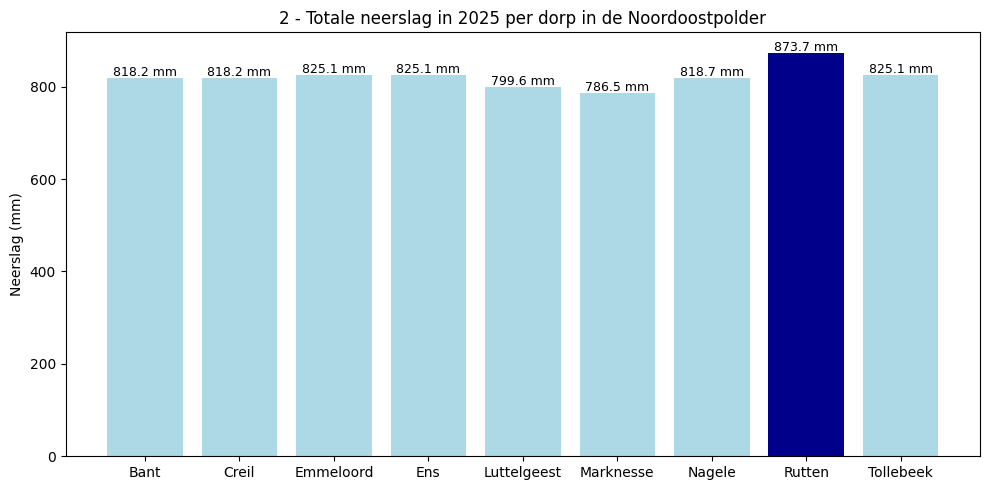

In [63]:
### VISUAL 2: Totale neerslag in 2025 per dorp in de Noordoostpolder ###

# plotten van de bar chart
fig2 = plt.figure(figsize=(10,5))

# dorp met meeste neerslag bepalen
max_value = df_neerslag_2025["neerslag_mm"].max()
max_dorp = df_neerslag_2025.loc[df_neerslag_2025["neerslag_mm"].idxmax(), "dorp"]

# kleurenlijst genereren
colors = [
    "darkblue" if dorp == max_dorp else "lightblue"
    for dorp in df_neerslag_2025["dorp"]
]

# bars tekenen
plt.bar(df_neerslag_2025["dorp"], df_neerslag_2025["neerslag_mm"], color=colors)

# waarden boven de bars tonen
for i, value in enumerate(df_neerslag_2025["neerslag_mm"]):   # loop door alle neerslagwaarden met index
    plt.text(                                                 # plaats tekst boven elke bar
        i, value + 4,                                         # positie iets boven de bar
        f"{value:.1f} mm",                                    # tekst met één decimaal en eenheden
        ha="center",                                          # horizontaal centreren boven de bar
        fontsize=9,                                           # kleine, nette tekstgrootte
        color="black"                                         # zwarte tekst voor goede leesbaarheid
    )

# titels en labels
plt.title("2 - Totale neerslag in 2025 per dorp in de Noordoostpolder")
plt.xlabel("")
plt.ylabel("Neerslag (mm)")

# layout en tonen
plt.tight_layout() # layout optimaliseren, geen overlapping etc
plt.show() # plot tonen

# visual toevoegen aan lijst
all_figures.append(fig2)



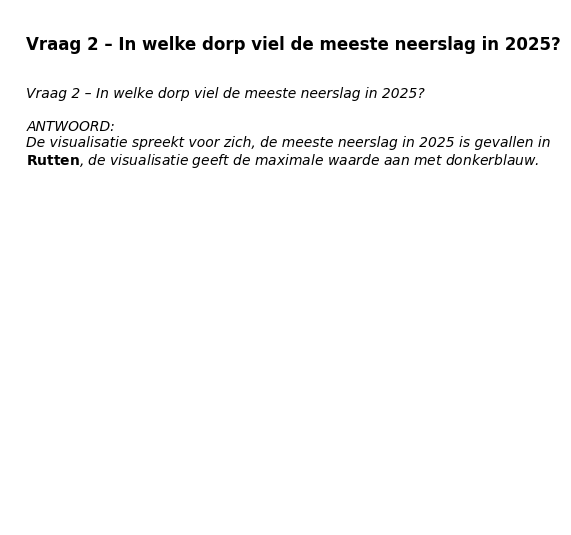

In [64]:
# vraag 2 dynamisch beantwoorden + toevoegen aan rapport
antwoord_vraag_2 = (
    "Vraag 2 – In welke dorp viel de meeste neerslag in 2025?\n"
    f"\n"
    f"ANTWOORD:" 
    f"\n"
    f"De visualisatie spreekt voor zich, de meeste neerslag in 2025 is gevallen in $\\mathbf{{{max_dorp}}}$, de visualisatie geeft de maximale waarde aan met donkerblauw."
)

fig_vraag_2 = create_text_page(antwoord_vraag_2, title="Vraag 2 – In welke dorp viel de meeste neerslag in 2025?")
all_figures.append(fig_vraag_2)

### 3. *Welke dorpen hadden de hoogste windsnelheden in de periode van 2020-2025?*

Deze vraag gaan we beantwoorden door te groeperen op dorp en jaar en vervolgens filteren op de periode 2020-2025.<br> 
Daarna pakken we de maximale windsnelheid van elk jaar en hiervan berekenen we het gemiddelde voor elke dorp.<br>
We gebruiken hiervoor owederom de historische dataset van Open-Meteo.<br>
In de volgende stap kgaan we eerst de dataframe maken.

In [65]:
# gemiddelde maximale windsnelheid gefilterd op 2020 -2025 per dorp op basis van Open-Meteo data (dagelijkse windsnelheidmeting)

# filteren op jaren 2020-2025
df_wind_2020_2025 = df_openmeteo[df_openmeteo["jaar"].between(2020, 2025)]

# jaarlijkse maximale windsnelheid per dorp
df_max_wind_yearly_2020_2025 = (
    df_wind_2020_2025.groupby(["dorp", "jaar"])["max_windsnelheid"]
    .max()
    .reset_index()
)


# gemiddelde van de jaarlijkse maximale windsnelheid per dorp over 2020-2025
df_max_wind_avg_2020_2025 = (
    df_max_wind_yearly_2020_2025.groupby("dorp")["max_windsnelheid"]
    .mean()
    .round(1)
    .reset_index()
    .rename(columns={"max_windsnelheid": "max_windsnelheid_gem"})
    .sort_values("max_windsnelheid_gem", ascending=False)
)

# resultaten bekijken
#df_max_wind_avg_2020_2025.head(15)

Hieronder de visualisatie om vraag 3 te beantwoorden:

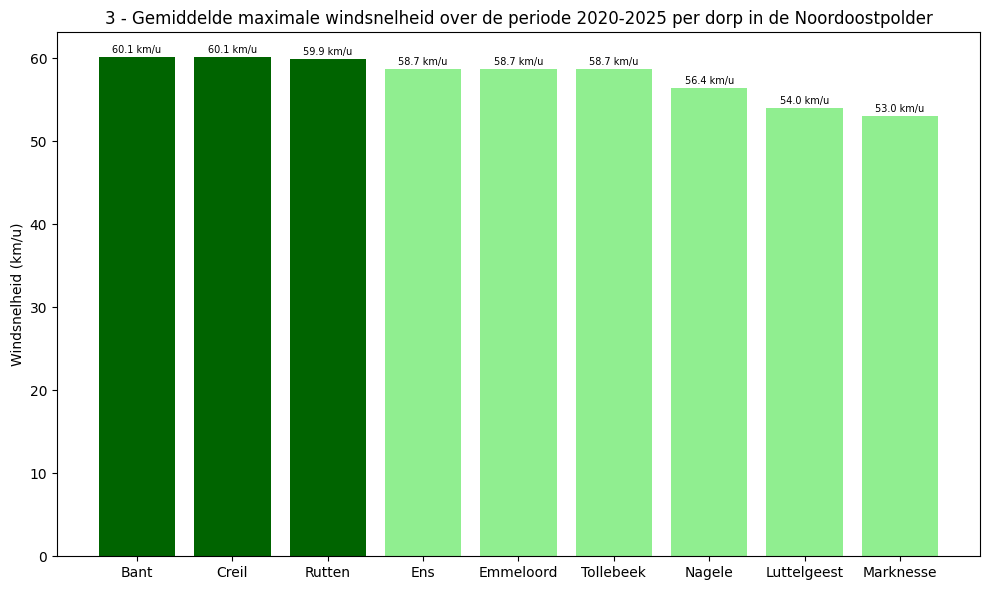

In [66]:
### VISUAL 3: Gemiddelde maximale windsnelheid over de periode 2020-2025 per dorp in de Noordoostpolder ###

fig3 = plt.figure(figsize=(10,6))

# top 3 dorpen bepalen
top3_dorpen = df_max_wind_avg_2020_2025.nlargest(3, "max_windsnelheid_gem")["dorp"].tolist() # lijst van top 3 dorpen

# kleurenlijst genereren
colors = [                                                # maak een lijst met kleuren voor elke bar
    "darkgreen" if dorp in top3_dorpen else "lightgreen"  # top 3 dorpen krijgen donker groen, rest licht groen
    for dorp in df_max_wind_avg_2020_2025["dorp"]         # loop door alle dorpen in de dataset
]

# bars tekenen
plt.bar(                                                  # teken de staafdiagram
    df_max_wind_avg_2020_2025["dorp"],                    # x-as: dorpsnamen
    df_max_wind_avg_2020_2025["max_windsnelheid_gem"],    # y-as: maximale gemiddelde windsnelheid
    color=colors                                          # gebruik de eerder gemaakte kleurenlijst
)

# waarden boven de bars tonen
for i, value in enumerate(df_max_wind_avg_2020_2025["max_windsnelheid_gem"]):   # loop door alle waarden met index
    plt.text(                                             # plaats tekst boven elke bar
        i, value + 0.5,                                   # positie iets boven de bar
        f"{value:.1f} km/u",                              # tekst met één decimaal en eenheid
        ha="center",                                      # horizontaal centreren
        fontsize=7,                                       # kleine tekst voor nette weergave
        color="black"                                     # zwarte tekst voor goede leesbaarheid
    )

# titels en label
plt.title("3 - Gemiddelde maximale windsnelheid over de periode 2020-2025 per dorp in de Noordoostpolder")
plt.xlabel("")
plt.ylabel("Windsnelheid (km/u)")

# layout en tonen
plt.tight_layout() # layout optimaliseren, geen overlapping etc
plt.show() # plot tonen

# visual toevoegen aan lijst
all_figures.append(fig3)

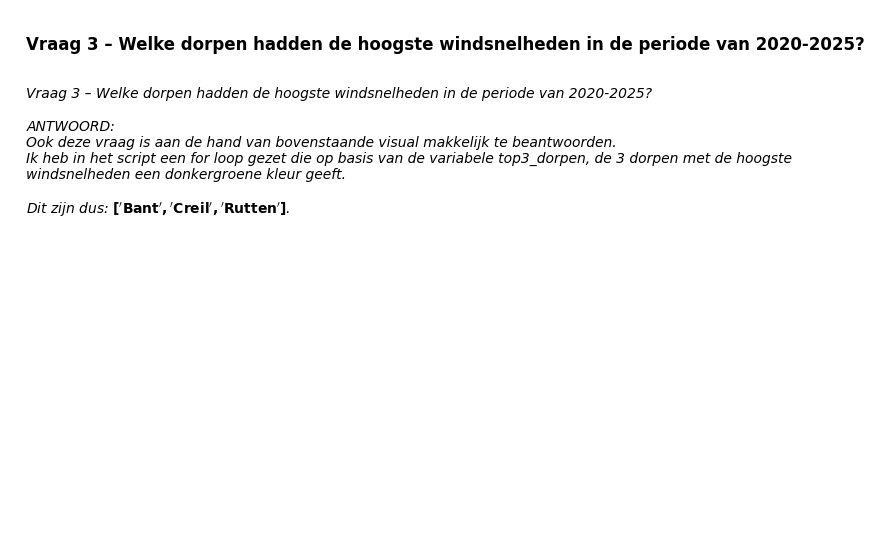

In [67]:
# vraag 3 dynamisch beantwoorden + toevoegen aan rapport
antwoord_vraag_3 = (
    "Vraag 3 – Welke dorpen hadden de hoogste windsnelheden in de periode van 2020-2025?\n"
    f"\n"
    f"ANTWOORD:"
    f"\n"
    "Ook deze vraag is aan de hand van bovenstaande visual makkelijk te beantwoorden.\n"
    "Ik heb in het script een for loop gezet die op basis van de variabele top3_dorpen, "
    f"de 3 dorpen met de hoogste windsnelheden een donkergroene kleur geeft.\n"
    f"\n"
    f"Dit zijn dus: $\\mathbf{{{top3_dorpen}}}$."
)

fig_vraag_3 = create_text_page(antwoord_vraag_3, title="Vraag 3 – Welke dorpen hadden de hoogste windsnelheden in de periode van 2020-2025?")
all_figures.append(fig_vraag_3)


### 4. *In welk dorp(en) is het nu het warmst/koudst?*

Voor deze vraag gebruiken we de actuele dataset van de Met Norway API.<br>
We maken een dataframe met de kolommen: dorp, dag, uur, temp.<br>
Vervolgens gebruiken we dit specifieke dataframe om te visualiseren en de vraag te beantwoorden.

In [68]:
# actuele temperatuur per dorp op basis van Met Norway data (actuele uurlijkse meting)

# alleen relevante kolommen selecteren
df_actual_temp_hour = df_metnorway[["dorp", "dag", "uur", "temp"]]

# datum vandaag en uur bepalen
nu = datetime.now()
huidige_dag = nu.strftime("%Y-%m-%d")
huidig_uur = f"{nu.hour}:00"

# datum vandaag en uur bepalen
df_actual_temp_hour = df_metnorway[
    (df_metnorway["dag"] == huidige_dag) &
    (df_metnorway["uur"] == huidig_uur)
]

# resultaten bekijken
#df_actual_temp_hour.head(10)

Hieronder de visualisatie om vraag 4 te beantwoorden:

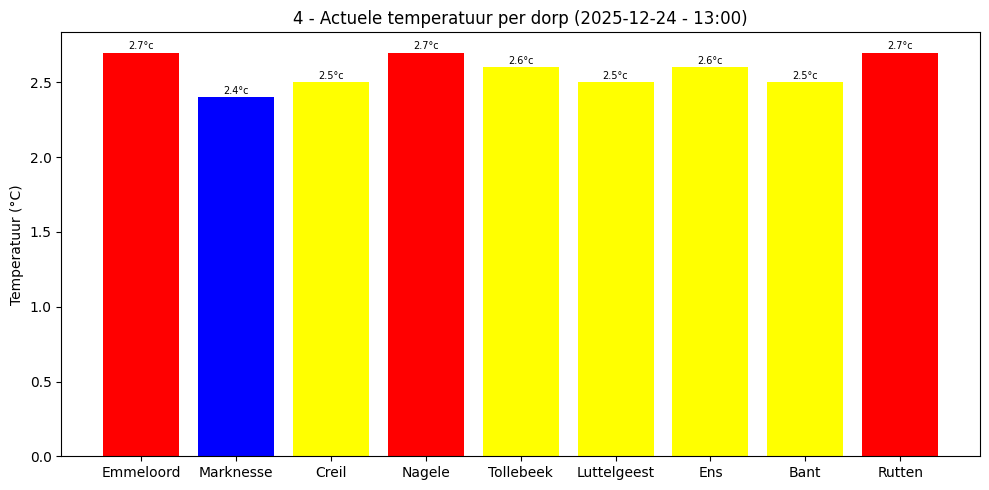

In [69]:
### VISUAL 4: Actuele temperatuur per dorp op basis van Met Norway data (actuele uurlijkse meting) ###

fig4 = plt.figure(figsize=(10,5))

# hoogste en laagste temperatuur bepalen
max_temp = df_actual_temp_hour["temp"].max()
min_temp = df_actual_temp_hour["temp"].min()

# alle dorpen met hoogste temperatuur
warmste_dorpen = df_actual_temp_hour.loc[
    df_actual_temp_hour["temp"] == max_temp, "dorp"
].tolist() # geeft een lijst als meerdere dorpen een gelijke waarde hebben

# alle dorpen met laagste temperatuur
koudste_dorpen = df_actual_temp_hour.loc[
    df_actual_temp_hour["temp"] == min_temp, "dorp"
].tolist() # geeft een lijst als meerdere dorpen een gelijke waarde hebben

# kleurenlijst genereren
colors = [                                                # maak een kleurenlijst op basis van temperatuurwaarden
    "red" if t == max_temp else                           # hoogste temperatuur krijgt rood
    "blue" if t == min_temp else                          # laagste temperatuur krijgt blauw
    "yellow"                                              # alle overige temperaturen krijgen geel
    for t in df_actual_temp_hour["temp"]                  # loop door alle temperatuurwaarden
]

# bars tekenen
bars = plt.bar(                                           # teken de staafdiagram
    df_actual_temp_hour["dorp"],                          # x-as: dorpsnamen
    df_actual_temp_hour["temp"],                          # y-as: temperatuurwaarden
    color=colors                                          # gebruik de gegenereerde kleurenlijst
)

# datalabels toevoegen via bar container
for bar in bars:                                          # loop door alle bars in de grafiek
    height = bar.get_height()                             # haal de hoogte (temperatuurwaarde) van de bar op
    plt.text(                                             # plaats tekst boven de bar
        bar.get_x() + bar.get_width() / 2,                # horizontale positie: midden van de bar
        height + 0.025,                                   # verticale positie: iets boven de bar
        f"{height:.1f}°c",                                # tekst met één decimaal en graden
        ha="center",                                      # horizontaal centreren
        fontsize=7,                                       # kleine tekstgrootte
        color="black"                                     # zwarte tekst voor goede leesbaarheid
    )


# titels en label
plt.title(f"4 - Actuele temperatuur per dorp ({huidige_dag} - {huidig_uur})")
plt.xlabel("")
plt.ylabel("Temperatuur (°C)")

plt.subplots_adjust(left=0.08, right=0.95)
plt.tight_layout() # layout optimaliseren, geen overlapping etc
plt.show()

# visual toevoegen aan lijst
all_figures.append(fig4)

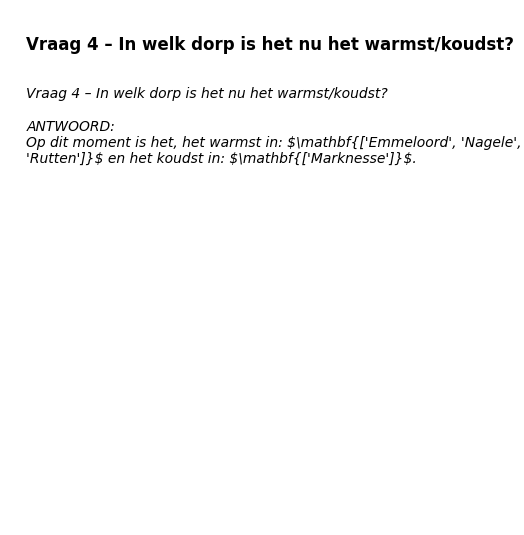

In [70]:
# vraag 4 dynamisch beantwoorden + toevoegen aan rapport
antwoord_vraag_4 = (
    "Vraag 4 – In welk dorp is het nu het warmst/koudst?\n"
    f"\n"
    f"ANTWOORD:\n"
    f"Op dit moment is het, het warmst in: $\\mathbf{{{warmste_dorpen}}}$ en het koudst in: $\\mathbf{{{koudste_dorpen}}}$.\n"
)

fig_vraag_4 = create_text_page(antwoord_vraag_4, title="Vraag 4 – In welk dorp is het nu het warmst/koudst?")
all_figures.append(fig_vraag_4)


### 5. *Wat is de verwachting m.b.t. tempratuur/neerslag/windsnelheid voor de komende dagen in de dorpen van de Noordoostpolder?*

Voor deze vraag gebruiken we weer de actuele dataset van de Met Norway API.<br>
We maken een dataframe met de kolommen: dorp, dag, uur, temperatuur, neerslag en windsnelheid.<br>
Vervolgens gebruiken we dit specifieke dataframe om te visualiseren en de vraag te beantwoorden.

In [71]:
# weersverwachting per dorp op basis van Open-Meteo data (dagelijks waardes)

df_weer_forecast = (
    df_metnorway
    .groupby(["dorp","dag"]) # groeperen op dorp en dag
    .agg(
        max_temp=("temp", "max"), # max temperatuur
        min_temp=("temp", "min"), # min temperatuur
        total_neerslag=("neerslag_mm", "sum"), # totale neerslag optellen
         avg_wind=("windsnelheid", lambda x: round(x.mean())) # windsnelheid afronden naar heel getal
)
    .reset_index()
)

# kolom dag omzetten naar datetime
df_weer_forecast["dag"] = pd.to_datetime(df_weer_forecast["dag"])

# datum vandaag + dynamische eind datum instellen
vandaag = pd.to_datetime(datetime.now().date())
eind_datum = vandaag + pd.Timedelta(days=2)

# dataframe met forecast voor komende 3 dagen instellen
df_weer_forecast_3dagen = df_weer_forecast[
    (df_weer_forecast["dag"] >= vandaag) &
    (df_weer_forecast["dag"] <= eind_datum)
]

# resultaten bekijken
#df_weer_forecast_3dagen.head(10)


Hieronder de visualisatie om vraag 5 te beantwoorden:

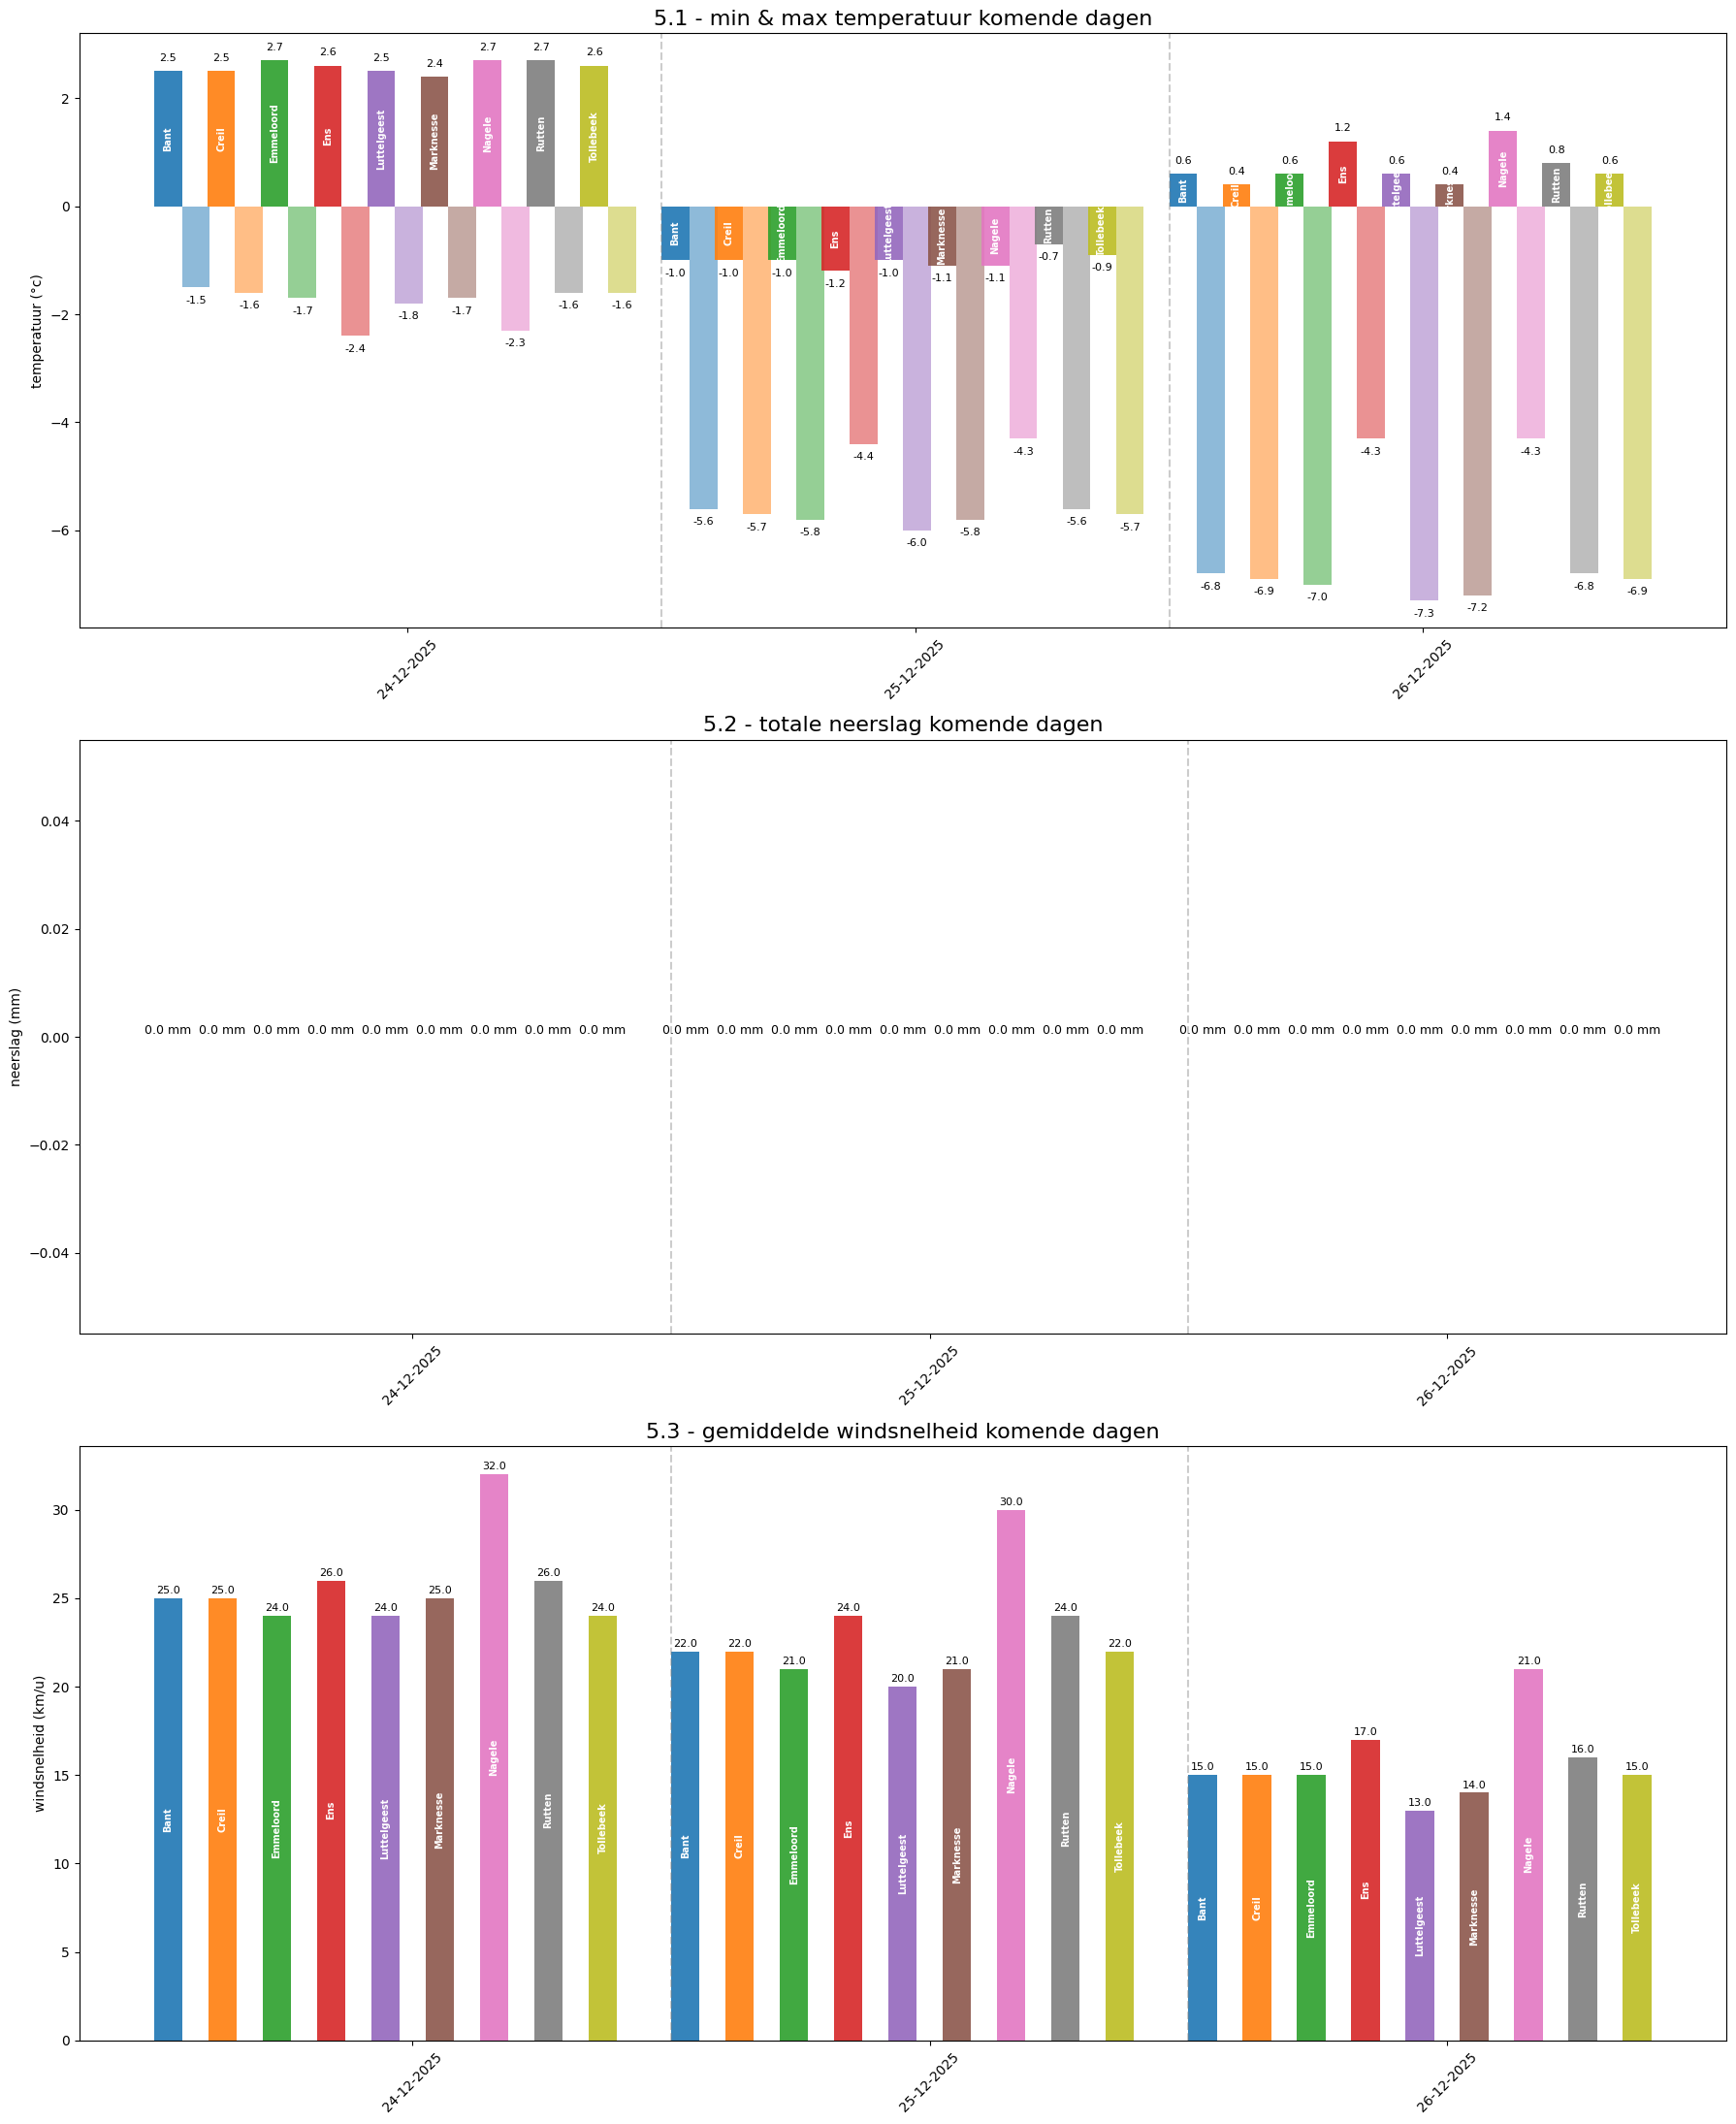

In [72]:
### VISUAL 5: Weersverwachting komende 3 dagen voor alle dorpen ###

### GECOMBINEERDE VISUAL: 5.1 + 5.2 + 5.3 ###

df = df_weer_forecast_3dagen.copy()                         # kopieer de forecast-dataframe
dagen = df["dag"].unique()                                  # unieke dagen ophalen
dorpen = df["dorp"].unique()                                # unieke dorpen ophalen

x = np.arange(len(dagen))                                   # x-positie voor elke dag
width = 0.055                                               # breedte van elke bar
group_spacing = 0.05                                        # ruimte tussen groepen bars

colors = {dorp: plt.cm.tab10(i) for i, dorp in enumerate(dorpen)}   # kleurmapping per dorp

fig5, axes5 = plt.subplots(3, 1, figsize=(18, 22))          # figuur met 3 subplots onder elkaar


# ---------------------------------------------------------
# 5.1 min/max temperatuur
# ---------------------------------------------------------
ax = axes5[0]                                               # selecteer eerste subplot

for i, dorp in enumerate(dorpen):                           # loop door alle dorpen
    df_dorp = df[df["dorp"] == dorp]                        # filter data voor dit dorp
    offset = (i - len(dorpen)/2) * (width + group_spacing)  # bereken offset voor gegroepeerde bars

    bars_max = ax.bar(                                      # teken max-temp bars
        x + offset,
        df_dorp["max_temp"],
        width,
        color=colors[dorp],
        alpha=0.9
    )

    bars_min = ax.bar(                                      # teken min-temp bars
        x + offset + width,
        df_dorp["min_temp"],
        width,
        color=colors[dorp],
        alpha=0.5
    )

    for bar in bars_max:                                    # dorpnaam in max-bars zetten
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h * 0.5,
            dorp,
            rotation=90,
            ha="center",
            va="center",
            fontsize=7,
            color="white",
            fontweight="bold"
        )

    for bar in list(bars_max) + list(bars_min):             # waardelabels boven/onder bars
        h = bar.get_height()
        y = h + 0.15 if h >= 0 else h - 0.15
        va = "bottom" if h >= 0 else "top"
        ax.text(
            bar.get_x() + bar.get_width()/2,
            y,
            f"{h:.1f}",
            ha="center",
            va=va,
            fontsize=8
        )

for i in range(len(dagen) - 1):                             # verticale scheidingslijnen
    ax.axvline(i + 0.5, color="grey", linestyle="--", alpha=0.4)

ax.set_title("5.1 - min & max temperatuur komende dagen", fontsize=16)
ax.set_ylabel("temperatuur (°c)")
ax.set_xticks(x)
ax.set_xticklabels([d.strftime("%d-%m-%Y") for d in dagen], rotation=45)


# ---------------------------------------------------------
# 5.2 neerslag
# ---------------------------------------------------------
ax = axes5[1]                                               # tweede subplot

for i, dorp in enumerate(dorpen):
    df_dorp = df[df["dorp"] == dorp]
    offset = (i - len(dorpen)/2) * (width + group_spacing)

    bars = ax.bar(                                          # teken neerslag-bars
        x + offset,
        df_dorp["total_neerslag"],
        width,
        color=colors[dorp],
        alpha=0.9
    )

    for bar in bars:                                        # dorpnaam in bars
        h = bar.get_height()

        ax.text(
            bar.get_x() + bar.get_width()/2,
            h * 0.5,
            dorp,
            rotation=90,
            ha="center",
            va="center",
            fontsize=7,
            color="white",
            fontweight="bold"
        )

        ax.text(                                            # neerslagwaarde boven bar
            bar.get_x() + bar.get_width()/2,
            h + 0.0,
            f"{h:.1f} mm",
            ha="center",
            va="bottom",
            fontsize=9
        )

for i in range(len(dagen) - 1):
    ax.axvline(i + 0.5, color="grey", linestyle="--", alpha=0.4)

ax.set_title("5.2 - totale neerslag komende dagen", fontsize=16)
ax.set_ylabel("neerslag (mm)")
ax.set_xticks(x)
ax.set_xticklabels([d.strftime("%d-%m-%Y") for d in dagen], rotation=45)


# ---------------------------------------------------------
# 5.3 windsnelheid
# ---------------------------------------------------------
ax = axes5[2]                                               # derde subplot

for i, dorp in enumerate(dorpen):
    df_dorp = df[df["dorp"] == dorp]
    offset = (i - len(dorpen)/2) * (width + group_spacing)

    bars = ax.bar(                                          # teken wind-bars
        x + offset,
        df_dorp["avg_wind"],
        width,
        color=colors[dorp],
        alpha=0.9
    )

    for bar in bars:                                        # dorpnaam in bars
        h = bar.get_height()

        ax.text(
            bar.get_x() + bar.get_width()/2,
            h * 0.5,
            dorp,
            rotation=90,
            ha="center",
            va="center",
            fontsize=7,
            color="white",
            fontweight="bold"
        )

        ax.text(                                            # windsnelheid boven bar
            bar.get_x() + bar.get_width()/2,
            h + 0.15,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

for i in range(len(dagen) - 1):
    ax.axvline(i + 0.5, color="grey", linestyle="--", alpha=0.4)

ax.set_title("5.3 - gemiddelde windsnelheid komende dagen", fontsize=16)
ax.set_ylabel("windsnelheid (km/u)")
ax.set_xticks(x)
ax.set_xticklabels([d.strftime("%d-%m-%Y") for d in dagen], rotation=45)


plt.tight_layout() # layout optimaliseren, geen overlapping etc
plt.show()

# visual toevoegen aan lijst
all_figures.append(fig5)


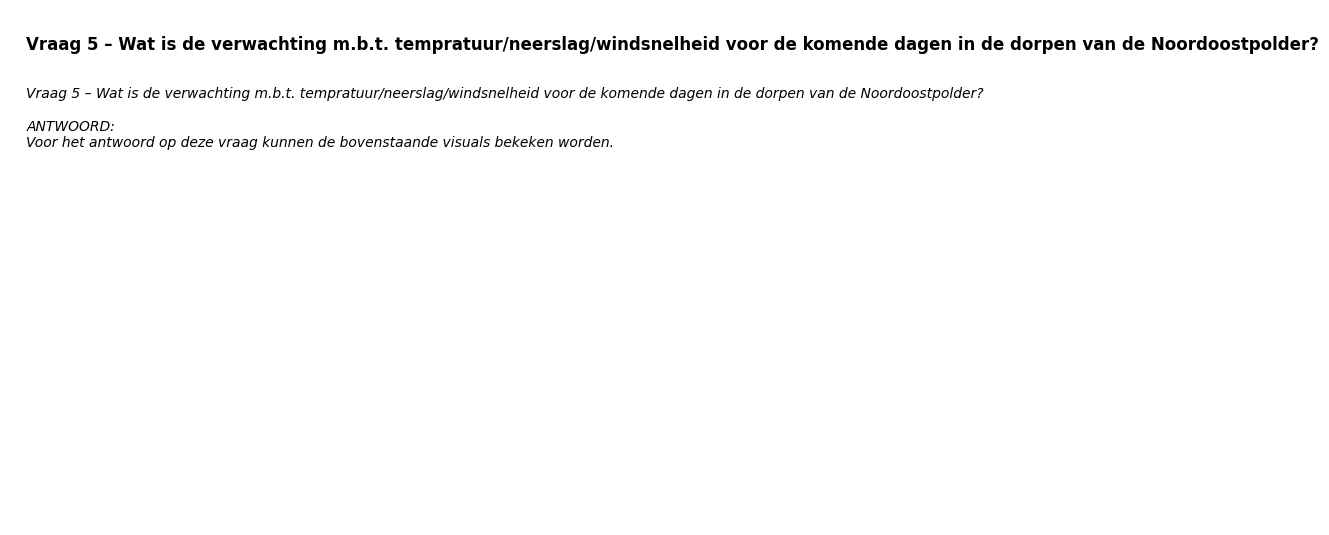

In [73]:
# vraag 5 dynamisch beantwoorden + toevoegen aan rapport
antwoord_vraag_5 = (
    "Vraag 5 – Wat is de verwachting m.b.t. tempratuur/neerslag/windsnelheid voor de komende dagen in de dorpen van de Noordoostpolder?\n"
    f"\n"
    "ANTWOORD:" 
    f"\n"
    "Voor het antwoord op deze vraag kunnen de bovenstaande visuals bekeken worden."
)

fig_vraag_5 = create_text_page(antwoord_vraag_5, title="Vraag 5 – Wat is de verwachting m.b.t. tempratuur/neerslag/windsnelheid voor de komende dagen in de dorpen van de Noordoostpolder?")
all_figures.append(fig_vraag_5)


### 6. *Hoe groot zijn de verschillen in temperatuur, neerslag en windsnelheid tussen de dorpen van de Noordoostpolder vandaag?*

Voor deze vraag gebruiken we ook weer de actuele dataset van de Met Norway API.<br>
We maken een zelfde dataframe met de kolommen: dorp, dag, uur, temperatuur, neerslag en windsnelheid.<br>
Nu gaan we de verschillen berekenen in temperatuur, neerslag en windsnelheid voor datum vandaag.<br>
Vervolgens gebruiken we dit specifieke dataframe weer om te visualiseren en de vraag te beantwoorden.

In [74]:
# verschillen in temp/neerslag/windsnelheid per dorp op basis van Open-Meteo data (vandaag)

# kolom dag omzetten naar datetime en windsnelhied afronden
df_metnorway["dag"] = pd.to_datetime(df_metnorway["dag"])
df_metnorway["windsnelheid"] = df_metnorway["windsnelheid"].round().astype(int)

# datum vandaag + huidig uur ophalen
datum_vandaag = pd.to_datetime(datetime.now().date())
huidig_uur = f"{datetime.now().hour:02d}:00"

# dataframe met data vandaag
df_weer_vandaag = df_metnorway[
    (df_metnorway["dag"] == datum_vandaag) & (df_metnorway["uur"] == huidig_uur)  
]

# resultaten bekijken
#df_weer_vandaag.head(10)

# extra dataframe met min/max waardes 
df_weer_vandaag_min_max = (df_weer_vandaag     
        .groupby(["dag", "uur"]) # groeperen op dorp en dag
        .agg(
            min_temp=("temp", "min"), # max temperatuur
            max_temp=("temp", "max"), # min temperatuur
            min_neerslag=("neerslag_mm", "min"), # min neerslag
            max_neerslag=("neerslag_mm", "max"), # max neerslag
            min_wind=("windsnelheid", "min"), # min windsnelheid
            max_wind=("windsnelheid", "max"), # max windsnelheid
        )
        .reset_index()
)

# resultaten bekijken
#df_weer_vandaag_min_max.head(10)

# verschillen als variabelen defineren
temp_verschil = (df_weer_vandaag_min_max["max_temp"] - df_weer_vandaag_min_max["min_temp"]).iloc[0].round(1)
neerslag_verschil = (df_weer_vandaag_min_max["max_neerslag"] - df_weer_vandaag_min_max["min_neerslag"]).iloc[0].round(1)
wind_verschil = (df_weer_vandaag_min_max["max_wind"] - df_weer_vandaag_min_max["min_wind"]).iloc[0].round(1)



Hieronder de visualisatie om vraag 6 te beantwoorden:

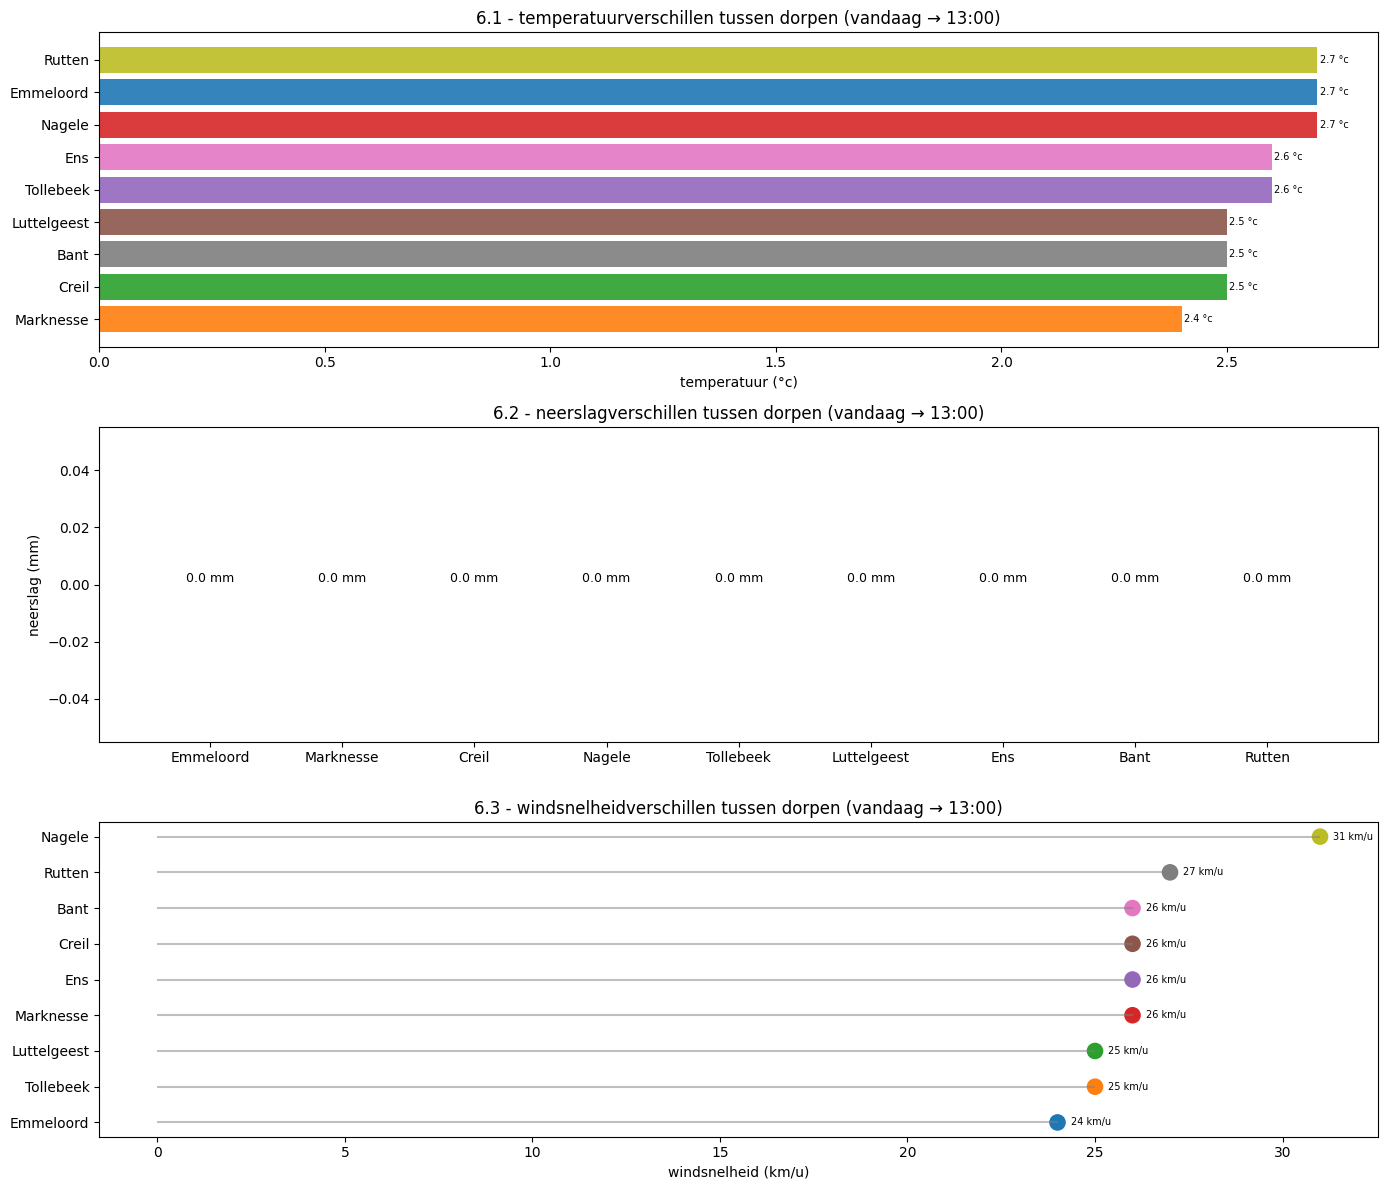

In [75]:
### VISUAL 6: Verschillen temp/neerslag/windsnelheid tussen de dorpen (vandaag, huidig uur) ###

### gecombineerde visual: 6.1 + 6.2 + 6.3 ###

dorpen = df_weer_vandaag["dorp"].unique()                   # unieke dorpen ophalen
colors = {dorp: plt.cm.tab10(i) for i, dorp in enumerate(dorpen)}   # kleurmapping per dorp
fig6, axes6 = plt.subplots(3, 1, figsize=(14, 12))          # figuur met 3 subplots


# ---------------------------------------------------------
# 6.1 temperatuurverschillen
# ---------------------------------------------------------
ax = axes6[0]                                               # eerste subplot selecteren

temps = df_weer_vandaag.set_index("dorp")["temp"].sort_values()   # temperaturen sorteren per dorp

bars = ax.barh(                                             # horizontale bars tekenen
    temps.index,
    temps.values,
    color=[colors[d] for d in temps.index],
    alpha=0.9
)

offset = 0.005                                              # kleine offset voor labels
for bar in bars:                                            # loop door alle bars
    width = bar.get_width()                                 # breedte = temperatuurwaarde
    if width >= 0:                                          # positieve waarden rechts labelen
        x = width + offset
        ha = "left"
    else:                                                   # negatieve waarden links labelen
        x = width - offset
        ha = "right"

    ax.text(                                                # tekst naast de bar
        x,
        bar.get_y() + bar.get_height()/2,
        f"{width:.1f} °c",
        va="center",
        ha=ha,
        fontsize=7
    )

ax.set_title(f"6.1 - temperatuurverschillen tussen dorpen (vandaag → {huidig_uur})")
ax.set_xlabel("temperatuur (°c)")


# ---------------------------------------------------------
# 6.2 neerslagverschillen
# ---------------------------------------------------------
ax = axes6[1]                                               # tweede subplot

vals = df_weer_vandaag.set_index("dorp")["neerslag_mm"].sort_values()   # neerslag sorteren

bars = ax.bar(                                              # verticale bars tekenen
    vals.index,
    vals.values,
    color=[colors[d] for d in vals.index],
    alpha=0.9
)

offset = 0.0                                                # offset voor labels
for bar in bars:
    height = bar.get_height()                               # hoogte = neerslagwaarde
    ax.text(                                                # label boven de bar
        bar.get_x() + bar.get_width()/2,
        height + offset,
        f"{height:.1f} mm",
        ha="center",
        va="bottom",
        fontsize=9
    )

ax.set_title(f"6.2 - neerslagverschillen tussen dorpen (vandaag → {huidig_uur})")
ax.set_ylabel("neerslag (mm)")


# ---------------------------------------------------------
# 6.3 windsnelheidverschillen
# ---------------------------------------------------------
ax = axes6[2]                                               # derde subplot

vals = df_weer_vandaag.set_index("dorp")["windsnelheid"].sort_values()   # windsnelheden sorteren
dorpen_sorted = vals.index                                  # gesorteerde dorpen
colors_sorted = {dorp: plt.cm.tab10(i) for i, dorp in enumerate(dorpen_sorted)}   # nieuwe kleurmapping

# lijn
ax.hlines(                                                  # horizontale lijnen tekenen
    y=dorpen_sorted,
    xmin=0,
    xmax=vals.values,
    color="grey",
    alpha=0.5
)

# bolletjes
ax.scatter(                                                 # punten op de lijn
    vals.values,
    dorpen_sorted,
    color=[colors_sorted[d] for d in dorpen_sorted],
    s=120
)

offset = 0.35                                               # offset voor labels
for dorp, value in vals.items():                            # labels naast de bolletjes
    ax.text(
        value + offset,
        dorp,
        f"{value:.0f} km/u",
        va="center",
        ha="left",
        fontsize=7
    )

ax.set_title(f"6.3 - windsnelheidverschillen tussen dorpen (vandaag → {huidig_uur})")
ax.set_xlabel("windsnelheid (km/u)")


plt.tight_layout() # layout optimaliseren, geen overlapping etc
plt.show()

# visual toevoegen aan lijst
all_figures.append(fig6)


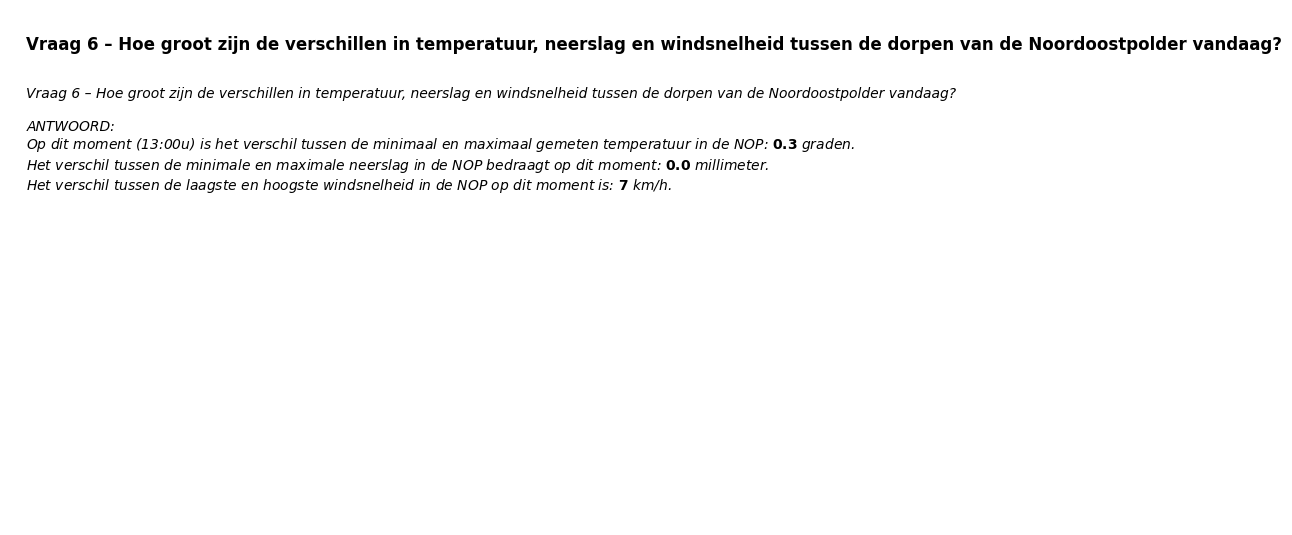

In [76]:
# vraag 6 dynamisch beantwoorden + toevoegen aan rapport
antwoord_vraag_6 = (
    "Vraag 6 – Hoe groot zijn de verschillen in temperatuur, neerslag en windsnelheid tussen de dorpen van de Noordoostpolder vandaag?\n"
    f"\n"
    f"ANTWOORD:"
    f"\n" 
    f"Op dit moment ({huidig_uur}u) is het verschil tussen de minimaal en maximaal gemeten "
    f"temperatuur in de NOP: $\\mathbf{{{temp_verschil}}}$ graden.\n"
    f"Het verschil tussen de minimale en maximale neerslag in de NOP bedraagt op dit moment: "
    f"$\\mathbf{{{neerslag_verschil}}}$ millimeter.\n"
    f"Het verschil tussen de laagste en hoogste windsnelheid in de NOP op dit moment is: "
    f"$\\mathbf{{{wind_verschil}}}$ km/h."
)


fig_vraag_6 = create_text_page(antwoord_vraag_6, title="Vraag 6 – Hoe groot zijn de verschillen in temperatuur, neerslag en windsnelheid tussen de dorpen van de Noordoostpolder vandaag?")
all_figures.append(fig_vraag_6)


## **Weer-rapport: Noordoostpolder**
Voer onderstaande code uit om de weer visuals samen te voegen in een PDF-rapport.

In [77]:

### PDF-RAPPORT GENEREREN ###

# data_timestamp om weer te geven op voorpagina
df_openmeteo["etl_timestamp"] = pd.to_datetime(df_openmeteo["etl_timestamp"])
df_metnorway["etl_timestamp"] = pd.to_datetime(df_metnorway["etl_timestamp"])
data1_date = df_openmeteo["etl_timestamp"].loc[0].strftime("%d-%m-%Y %H:%M")
data2_date = df_openmeteo["etl_timestamp"].loc[0].strftime("%d-%m-%Y %H:%M")

# functie om voorpagina te maken voor het pdf rapport
def create_cover_page(timestamp):                           # definieer een functie die een voorpagina-figuur maakt
    fig = plt.figure(figsize=(8.27, 11.69))                 # maak een figuur op a4-formaat
    plt.axis("off")                                         # zet de assen uit voor een schone pagina

    # titel
    plt.text(                                               # plaats de titel bovenaan de pagina
        0.5, 0.85,                                          # positie in het midden, hoog op de pagina
        "weerrapport noordoostpolder",                      # titeltekst in kleine letters
        ha="center",                                        # horizontaal centreren
        va="center",                                        # verticaal centreren op het punt
        fontsize=28,                                        # grote titeltekst
        fontweight="bold"                                   # vetgedrukt voor nadruk
    )

    # afbeelding
    img = plt.imread("images/dorpen.jpg")                  # lees de afbeelding in vanaf schijf
    plt.imshow(img, extent=[0.1, 0.9, 0.25, 0.75])          # toon de afbeelding op een groot middenvlak
    plt.axis("off")                                         # assen opnieuw uitzetten (imshow zet ze soms aan)

    # timestamp rechtsonder
    plt.text(                                               # plaats metadata rechtsonder op de pagina
        0.98, 0.02,                                         # positie bijna helemaal rechts en onderaan
        f"rapport gegenereerd op: {timestamp}\n"            # timestamp van rapportgeneratie
        f"peildatum - openmeteo-api: {data1_date}\n"        # datum van openmeteo-data
        f"peildatum - metnorway-api: {data2_date}",         # datum van metnorway-data
        ha="right",                                         # rechts uitlijnen
        va="bottom",                                        # onderkant van de tekst op y
        fontsize=8,                                         # kleine tekst voor metadata
        color="gray"                                        # subtiele grijze kleur
    )

    return fig                                              # geef de figuur terug voor tonen of opslaan

# dictionary maken om antwoorden en visuals met elkaar te koppelen
fig_answer_map = {
    fig1: antwoord_vraag_1,
    fig2: antwoord_vraag_2,
    fig3: antwoord_vraag_3,
    fig4: antwoord_vraag_4,
    fig5: antwoord_vraag_5,
    fig6: antwoord_vraag_6,
}

# timestamp maken voor bestandsnaam
timestamp = datetime.now().strftime("%d-%m-%Y %H:%M")

# bestandsnaam met timestamp
output_path = f"rapport\weer_overzicht_nop_{timestamp.replace(':','-').replace(' ','_')}.pdf"

with PdfPages(output_path) as pdf:

    # 1. voorpagina
    cover = create_cover_page(timestamp)
    pdf.savefig(cover, bbox_inches="tight")

    # 2. Alle figuren + bijbehorende antwoorden
    for fig in fig_answer_map:
        # visual
        pdf.savefig(fig, bbox_inches="tight")
        plt.close(cover)   # ← voorkomt notebook output


        # antwoordpagina
        answer_text = fig_answer_map[fig]
        answer_page = create_text_page(answer_text, title="Analyse")
        pdf.savefig(answer_page, bbox_inches="tight")
        plt.close(answer_page)   # ← voorkomt notebook output

print(f"PDF-rapport is opgeslagen: {output_path}")


PDF-rapport is opgeslagen: rapport\weer_overzicht_nop_24-12-2025_13-43.pdf
